In this notebook we'll be performing some analysis on the titanic dataset and using that analysis to build classifiers that predict survival on the titanic. Methods here include data wrangling using Pandas, visualization using Seaborn, logistic regression, SVM, and classification using an MLP network. Not included that may be used in future work is a decision tree.

In [62]:
# we'll start with our basic imports.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns


In [63]:
# and I happen to have the data set locally from a course I sat in on. We'll start by reading it in,
# checking its dimensions, and having a quick look at the data to get a feel for it.
titan = pd.read_csv("/Users/lena/Desktop/shit I need to move/Coursework/SML201_F2020/titanic.csv")
print(titan.head())
print(titan.shape)

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
(8

This data is relatively tidy looking at first glance, but could still use a little wrangling to make it both as clean and as numeric as possible. 

Firstly, names are not going to provide much information for classifying purposes, as they are unique to each individual. We will remove them from the data subset that we work with. Second, "Sex" is a variable that can be binarized, so we will replace it with the variable "male", that states in Boolean terms whether an individual is Male. 

In [64]:

titan['Male']=titan['Sex']=='male'
titan = titan.drop(["Sex"],axis = 1)

# The next thing we'll do is drop the Name column because it essentially contains no information.
titan = titan.drop(["Name"], axis = 1)

# Let's have a look at what we have done:
titan.head()


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Male
0,1,0,3,22.0,1,0,A/5 21171,7.2500,NaN,S,True
1,2,1,1,38.0,1,0,PC 17599,71.2833,C85,C,False
2,3,1,3,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,False
3,4,1,1,35.0,1,0,113803,53.1000,C123,S,False
4,5,0,3,35.0,0,0,373450,8.0500,NaN,S,True


There remain some messier pieces of data. For example, tickets seem to have multiple formats.
It appears that class 3 passengers did not have cabins.
Additionally, port from which people embarked is encoded with strings, rather than numbers,
and thus will be difficult to analyze quantitatively without conversion to numerical values.
To correct the Embarked issue, we encode them by number:

S = 1

C = 2

Q = 3

nan = 0


In [65]:

titan_Embarked_vals = titan.Embarked.unique()
titan.Embarked = titan.Embarked.fillna(0)
titan.Embarked = titan.Embarked.replace({'S': 1, 'C': 2,'Q': 3})

# Validate
titan.Embarked.unique()

array([1, 2, 3, 0])

A question we might ask is, when a person has family on board, will that increase their chance of survival? The 
associated theory is that family onboard may benefit from strength in number and in-group advocacy. Additionally, 
the boolean value stating the presence or absence of family may be a stronger indicator than the number or type of
family on board.
To measure this, we combine the Parch and SibSp columns and convert them to a boolean variable.


In [66]:
titan["Family"]=((titan.SibSp>0)|(titan.Parch>0))
titan.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Male,Family
0,1,0,3,22.0,1,0,A/5 21171,7.2500,NaN,1,True,True
1,2,1,1,38.0,1,0,PC 17599,71.2833,C85,2,False,True
2,3,1,3,26.0,0,0,STON/O2. 3101282,7.9250,NaN,1,False,False
3,4,1,1,35.0,1,0,113803,53.1000,C123,1,False,True
4,5,0,3,35.0,0,0,373450,8.0500,NaN,1,True,False


With the data now looking a bit tidier, we can start a visual analysis of it. In particular, we'll look at the correlation coefficients. This data is particularly intuitive when encoded in a heatmap.

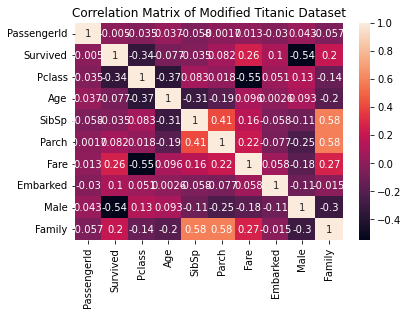

In [67]:

corr = titan.corr()
sns.heatmap(corr,annot = True)
plt.title('Correlation Matrix of Modified Titanic Dataset')
plt.show()



We can clearly see that sex and class provide the strongest correlations with survival. Fare is also a relatively strong predictor, as is family. However, fare is a proxy for class, so we will drop it in further classification efforts.

From here, we can do a little more analysis on these features. In particular, we would like to see the probabilities of survival given each category for sex and class. We summarize this data in the line plot below.

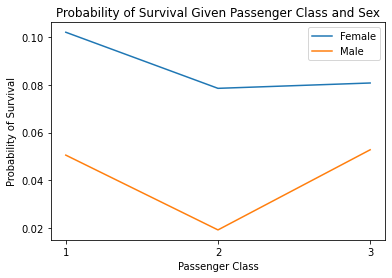

In [68]:

sf = titan[['Survived','Pclass','Male','Family','Embarked']]
titan_gen_survival = np.mean(sf['Survived']>0)
titan_male_survival = np.mean((sf['Survived']>0) & (sf['Male']>0))
# There are three classes. Of the men and women, separately, we'd like to see the survival rates per class:
survive_mat = np.zeros((2,3))
for cl in np.arange(1,4,1):
    for mf in np.arange(0,2,1):
        survive_mat[mf,cl-1]=np.mean((sf['Survived']>0) & ((sf['Male']==mf)&(sf['Pclass']==cl)))


plt.figure()
plt.plot(np.arange(1,4,1),np.transpose(survive_mat))
plt.legend(['Female','Male'])
plt.ylabel('Probability of Survival')
plt.xlabel('Passenger Class')
plt.xticks(np.arange(1,4,1))
plt.title('Probability of Survival Given Passenger Class and Sex')
plt.show()

 Now, clearly first class passengers were most likely to survive.
Interestingly, second class passengers were actually less likely to survive than third class.
Among women, this was a minor difference. However, among men, it was significant. 

It is important to note that this relationship is not linear, nor is it even monotonic. I am curious if we can do some basic logistic regression on this data. To do so, we need to fit a model, meaning we need to split the data into a training and test set. Fortunately, our old pal sci-kit learn has a simple tool for this.


In [69]:
from sklearn.model_selection import train_test_split

There are a few more pieces of data that aren't compatible with numerical fitting models. "Ticket", which will be correlated with fare, and "Cabin" which will also be correlated with fare. We drop these, as all are taken to be addressed by PClass. We note that age, although numeric, contains NANs. We drop these. Finally, we make training and test numpy arrays that we preprocess to improve fitting.

In [75]:
# For fitting purposes, we're going to start by converting our modified titan dataframe to a numpy array so that 
# it's compatible with various sklearn functions.
print(titan.head())
new_titan = titan.drop(['Ticket','Cabin','Fare'],axis = 1)
new_titan = new_titan.dropna()
print(new_titan.head())
tX = new_titan
tX = tX.drop('Survived',axis = 1)
tY = new_titan.Survived
tX = tX.to_numpy()
tY = tY.to_numpy()


   PassengerId  Survived  Pclass   Age  SibSp  Parch            Ticket  \
0            1         0       3  22.0      1      0         A/5 21171   
1            2         1       1  38.0      1      0          PC 17599   
2            3         1       3  26.0      0      0  STON/O2. 3101282   
3            4         1       1  35.0      1      0            113803   
4            5         0       3  35.0      0      0            373450   

      Fare Cabin  Embarked   Male  Family  
0   7.2500   NaN         1   True    True  
1  71.2833   C85         2  False    True  
2   7.9250   NaN         1  False   False  
3  53.1000  C123         1  False    True  
4   8.0500   NaN         1   True   False  
   PassengerId  Survived  Pclass   Age  SibSp  Parch  Embarked   Male  Family
0            1         0       3  22.0      1      0         1   True    True
1            2         1       1  38.0      1      0         2  False    True
2            3         1       3  26.0      0      0     

In [76]:
# Now we're going to split it into training and test sets
train_X, test_X, train_y, test_y = train_test_split(tX, tY, test_size=0.33,random_state = 1)
train_X

# after the split we're going to preprocess the data:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_X_SC = scaler.fit_transform(train_X)
test_X_SC = scaler.fit_transform(test_X)

Now that we have our data aplit up and preprocessed, we'll put a simple logistic model to work on it and see how well it handles this binary classification problem. Logistic models are simple, clean, fast, and a common method for binary classification.

In [77]:
# Now that we have a split, we'll throw it into a simple logistic regression model.
from sklearn.linear_model import LogisticRegression
log_reg_model = LogisticRegression(max_iter = 100).fit(train_X_SC,train_y)
dead = log_reg_model.predict(train_X_SC)
print('The accuracy of this logistic regression on the training set is: ',np.mean(dead==train_y))

dead = log_reg_model.predict(test_X_SC)
print('The accuracy of this logistic regression on the test set is: ',np.mean(dead==test_y))

# Simple logistic regression gives us 80 percent accuracy.

The accuracy of this logistic regression on the training set is:  0.803347280334728
The accuracy of this logistic regression on the test set is:  0.7923728813559322


This method provides approximately 80% acuracy on the test set. This is pretty solid, especially for a relatively small data set. However, we'd like to cross-validate with other methods. A support vector classifier using a nonlinear kernel comes to mind. We'll use SKLearn's SVC with the 'rbf' kernel to implement a classifier that works similarly to a weighted nearest neighbor.

In [78]:
from sklearn.svm import SVC
SVM = SVC(kernel = 'rbf')
SVM.fit(train_X_SC,train_y)
dead = SVM.predict(train_X_SC)
print('The accuracy of this logistic regression on the training set is: ',np.mean(dead==train_y))
dead = SVM.predict(test_X_SC)
print('The accuracy of this SVM on the test set is: ',np.mean(dead==test_y))


The accuracy of this logistic regression on the training set is:  0.8368200836820083
The accuracy of this SVM on the test set is:  0.8305084745762712


And sure enough, we get an almost 4% improvement in test set accuracy. 

The last thing we can do is throw the tech world's golden child at it by employing a nonlinear network, a multi-layer perceptron. We'll build one that first casts the data into a higher dimensional space and then slowly decodes that space back into a binary one. We'll employ a logistic activation function because our outputs are simply binary and employ an adaptive learning rate to avoid hovering around minima or getting stuck in a local minimum.

Furthermore, we're going to fit the network several times, each time giving it a warm start where it uses the previous converged state as an estimate for the new fit. This should allow convergence to a more effectiv fit. We'll keep the number of layers relatively small, hoping to avoid overfitting. Finally, because MLPs are especially sensitive to startin conditions, we'll cross-validate our chosen architecture using 100 different starting states.

In [91]:
from sklearn.neural_network import MLPClassifier
print(np.shape(train_X_SC))
acc_vec = np.zeros((100,2))
for trial in np.arange(0,100,1):
    clf = MLPClassifier(hidden_layer_sizes = (10,50,10,5),activation = 'logistic',learning_rate = 'adaptive',
                    random_state=trial,
                    max_iter=4000,warm_start = True)
    for i in np.arange(0,2500):
        clf.fit(train_X,train_y)

    dead = clf.predict(train_X)
    acc_vec[trial,0] = np.mean(dead == train_y)
    print('The accuracy of this MLP on the training set is: ',np.mean(dead==train_y))

    dead = clf.predict(test_X)
    acc_vec[trial,1] = np.mean(dead==test_y)
    print('The accuracy of this MLP on the test set is: ',np.mean(dead==test_y))
    print('----------------------------------------------------------')
    #print('accuracies: ',acc_vec)


(478, 8)
The accuracy of this MLP on the training set is:  0.8661087866108786
The accuracy of this MLP on the training set is:  0.788135593220339
----------------------------------------------------------
The accuracy of this MLP on the training set is:  0.8640167364016736
The accuracy of this MLP on the training set is:  0.8050847457627118
----------------------------------------------------------
The accuracy of this MLP on the training set is:  0.8430962343096234
The accuracy of this MLP on the training set is:  0.7923728813559322
----------------------------------------------------------
The accuracy of this MLP on the training set is:  0.8430962343096234
The accuracy of this MLP on the training set is:  0.809322033898305
----------------------------------------------------------
The accuracy of this MLP on the training set is:  0.8849372384937239
The accuracy of this MLP on the training set is:  0.8347457627118644
----------------------------------------------------------
The accu

The accuracy of this MLP on the training set is:  0.8535564853556485
The accuracy of this MLP on the training set is:  0.809322033898305
----------------------------------------------------------
The accuracy of this MLP on the training set is:  0.8682008368200836
The accuracy of this MLP on the training set is:  0.7711864406779662
----------------------------------------------------------
The accuracy of this MLP on the training set is:  0.8577405857740585
The accuracy of this MLP on the training set is:  0.8050847457627118
----------------------------------------------------------
The accuracy of this MLP on the training set is:  0.8765690376569037
The accuracy of this MLP on the training set is:  0.8050847457627118
----------------------------------------------------------
The accuracy of this MLP on the training set is:  0.8598326359832636
The accuracy of this MLP on the training set is:  0.7711864406779662
----------------------------------------------------------
The accuracy of 

The accuracy of this MLP on the training set is:  0.8577405857740585
The accuracy of this MLP on the training set is:  0.7669491525423728
----------------------------------------------------------
The accuracy of this MLP on the training set is:  0.8619246861924686
The accuracy of this MLP on the training set is:  0.7923728813559322
----------------------------------------------------------
The accuracy of this MLP on the training set is:  0.8305439330543933
The accuracy of this MLP on the training set is:  0.7711864406779662
----------------------------------------------------------
The accuracy of this MLP on the training set is:  0.8305439330543933
The accuracy of this MLP on the training set is:  0.7754237288135594
----------------------------------------------------------
The accuracy of this MLP on the training set is:  0.8640167364016736
The accuracy of this MLP on the training set is:  0.788135593220339
----------------------------------------------------------
The accuracy of 

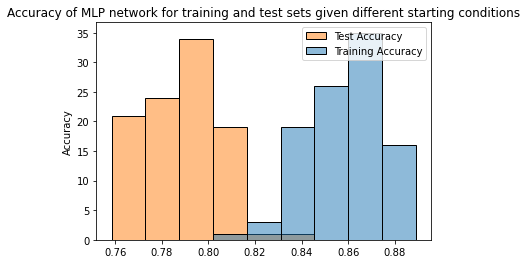

In [98]:

sns.histplot(data = acc_vec)
plt.legend(['Test Accuracy','Training Accuracy'])
plt.ylabel('Accuracy')
plt.title('Accuracy of MLP network for training and test sets given different starting conditions')
plt.show()

Clearly, the MLP network is able to perform well on the Test set and, for one starting point, outperformed the SVM classfier. However, in general, the SVM is our strongest performer of this set, and would be the one we recommend. 